In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import json

In [15]:
class Equirectangular:
    def __init__(self, img_name,kpts,lm_id):
        self._img = cv2.imread(img_name, cv2.IMREAD_COLOR)
        [self._height, self._width, _] = self._img.shape
        self.kpts=kpts
        self.lm_id=lm_id
        self.lm_map=self.get_lm_map()
        
    def get_lm_map(self):
        x,y,_=self._img.shape
        im=np.ones((x,y),dtype=np.uint32)*-1
        for i,kp in enumerate(self.kpts):
            im[int(kp[1]),int(kp[0])]=self.lm_id[i]
        return im
    
    def undistort_kpts(self,lon,lat):
        x,y=lon.shape
        undist_kpts=[]
        lm=[]
        for i in range(x):
            for j in range(y):
                xx,yy=int(lon[i,j]),int(lat[i,j])
                id_=self.lm_map[yy,xx]
                if id_!=-1:
                    undist_kpts.append([i,j])
                    lm.append(id_)
        return undist_kpts,lm
    
    def GetPerspective(self, FOV, THETA, PHI, height, width, RADIUS=128):
        equ_h = self._height
        equ_w = self._width
        equ_cx = (equ_w - 1) / 2.0
        equ_cy = (equ_h - 1) / 2.0
        wFOV = FOV
        hFOV = float(height) / width * wFOV
        c_x = (width - 1) / 2.0
        c_y = (height - 1) / 2.0

        wangle = (180 - wFOV) / 2.0
        w_len = 2 * RADIUS * np.sin(np.radians(wFOV / 2.0)) / np.sin(np.radians(wangle))
        w_interval = w_len / (width - 1)

        hangle = (180 - hFOV) / 2.0
        h_len = 2 * RADIUS * np.sin(np.radians(hFOV / 2.0)) / np.sin(np.radians(hangle))
        h_interval = h_len / (height - 1)
        x_map = np.zeros([height, width], np.float32) + RADIUS
        y_map = np.tile((np.arange(0, width) - c_x) * w_interval, [height, 1])
        z_map = -np.tile((np.arange(0, height) - c_y) * h_interval, [width, 1]).T
        D = np.sqrt(x_map ** 2 + y_map ** 2 + z_map ** 2)
        xyz = np.zeros([height, width, 3], float)
        xyz[:, :, 0] = (RADIUS / D * x_map)[:, :]
        xyz[:, :, 1] = (RADIUS / D * y_map)[:, :]
        xyz[:, :, 2] = (RADIUS / D * z_map)[:, :]

        y_axis = np.array([0.0, 1.0, 0.0], np.float32)
        z_axis = np.array([0.0, 0.0, 1.0], np.float32)
        [R1, _] = cv2.Rodrigues(z_axis * np.radians(THETA))
        [R2, _] = cv2.Rodrigues(np.dot(R1, y_axis) * np.radians(-PHI))

        xyz = xyz.reshape([height * width, 3]).T
        xyz = np.dot(R1, xyz)
        xyz = np.dot(R2, xyz).T
        lat = np.arcsin(xyz[:, 2] / RADIUS)
        lon = np.zeros([height * width], float)
        theta = np.arctan(xyz[:, 1] / xyz[:, 0])
        idx1 = xyz[:, 0] > 0
        idx2 = xyz[:, 1] > 0

        idx3 = ((1 - idx1) * idx2).astype(bool)
        idx4 = ((1 - idx1) * (1 - idx2)).astype(bool)

        lon[idx1] = theta[idx1]
        lon[idx3] = theta[idx3] + np.pi
        lon[idx4] = theta[idx4] - np.pi

        lon = lon.reshape([height, width]) / np.pi * 180
        lat = -lat.reshape([height, width]) / np.pi * 180
        lon = lon / 180 * equ_cx + equ_cx
        lat = lat / 90 * equ_cy + equ_cy
        
        kpts,lm=self.undistort_kpts(lon,lat)
        
        persp = cv2.remap(self._img, lon.astype(np.float32), lat.astype(np.float32), cv2.INTER_CUBIC,
                          borderMode=cv2.BORDER_WRAP)
        
        for pt in kpts:
            persp=cv2.circle(persp,(pt[1],pt[0]),color=[0,255,0],radius=4)
        img2 = persp[:,:,::-1]
        plt.imshow(img2)
        return persp

In [3]:
map_path='/home/endeleze/Desktop/WeNev/Mapping/Topomap/Output/GS010021/topo-map.json'
with open(map_path,'r') as f:
    data=json.load(f)['keyframes']

In [4]:
kpts=[i['pt'] for i in data['0006']['keypts']]
lm_id=data['0006']['lm_ids']

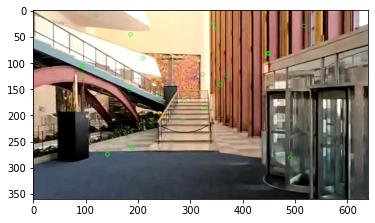

In [23]:
file='/home/endeleze/Desktop/WeNev/Mapping/data/src_images/GS010021/0006.png'
equ = Equirectangular(file,kpts,lm_id)
img = equ.GetPerspective(60, 0, 0, 360, 640)
img2 = img[:,:,::-1]
plt.imshow(img2)